## Лабораторная №2 (Селиванов, Деревянко, Кузьмина, Штыкина)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.decomposition import PCA
from numpy.linalg import svd
from sklearn.preprocessing import StandardScaler
import time
from typing import Callable, Union

$f(x) = \frac{1}{2} \left[(x_1)^2 + \sum_{i=1}^{2} (x_i - x_{i+1})^2 + (x_3)^2 \right] - x_1$


In [4]:
# Функция
def function(x):
    return 0.5 * (x[0]**2 + (x[0] - x[1])**2 + (x[1] - x[2])**2 + x[2]**2) - x[0]

In [5]:
# Аналитический градиент функции
def anal_grad_f(function, x):
    grad_x0 = 2 * x[0] - x[1] - 1
    grad_x1 = -x[0] + 2 * x[1] - x[2]
    grad_x2 = -x[1] + 2 * x[2]
    return np.array([grad_x0, grad_x1, grad_x2])

In [6]:
# Смещение точки в заданном измерении
def shift_dot(dot, shift, dim):
    new_dot = np.copy(dot)
    new_dot[dim] += shift
    return new_dot

# Производная в точке
def deriv_in_dot(function, dot, shift = 1e-2, dim = 0, method = 'central'):
    shift_plus = shift_dot(dot, shift, dim)
    if method == 'central':
        shift_minus = shift_dot(dot, - shift, dim)
        return (function(shift_plus) - function(shift_minus)) / (2 * shift)
    if method == 'forward':
        return (function(shift_plus) - function(dot)) / (shift)

print(deriv_in_dot(function, [11.0, 1, 2]))
print(anal_grad_f(function, [11.0, 1, 2]))

19.999999999999574
[ 20. -11.   3.]


In [7]:
# Числовой градиент функции
def numeric_grad_f(function, dot, shift = 1e-2, method = 'central'):
    grad_vector = np.array([deriv_in_dot(function, dot, shift = shift, dim = dim, method = method)
                            for dim in range(len(dot))])
    return grad_vector

n_grad = numeric_grad_f(function, [11.0, 1.0, 2.0])
print(n_grad)
print(anal_grad_f(function, [11.0, 1.0, 2.0]))

[ 20. -11.   3.]
[ 20. -11.   3.]


## Сильное условие Вольфе

In [8]:
# Strong condition zoom
def zoom(f, grad_f, x, p, c1, c2, alpha_low, alpha_high, max_iter):
    for i in range(max_iter):
        alpha_j = 0.5 * (alpha_low + alpha_high)
        f_alpha_j = f(x + alpha_j * p)

        if (f_alpha_j > f(x) + c1 * alpha_j * np.dot(grad_f(function, x), p)) or (f_alpha_j >= f(x + alpha_low * p)):
            alpha_high = alpha_j
        else:
            grad_value = grad_f(function, x + alpha_j * p)
            #if abs(np.dot(grad_value, p)) >= c2 * np.dot(grad_f(function, x), p):
            if np.linalg.norm(grad_value) <= -c2 * np.dot(grad_f(function, x), p):
                return alpha_j
            if np.dot(grad_value, p) * (alpha_high - alpha_low) >= 0:
                alpha_high = alpha_low
            alpha_low = alpha_j
    return alpha_j

## Слабое условие Вольфе

In [9]:
def line_search(f, grad_f, x, p, c1, c2, alpha_max, max_iter):
    i = 1
    alpha = 0

    for i in range(max_iter):

        alpha_pred = alpha
        alpha = (i * (alpha_max - 0.5)) / max_iter + 0.5

        # Вычисляем значение функции
        f_value = f(x + alpha * p)
        if (f_value > f(x) + c1 * alpha * np.dot(grad_f(function, x), p)) or ((f_value >= f(x + alpha_pred * p) and i > 1)):
            return zoom(f, grad_f, x, p, c1, c2, alpha_pred, alpha, max_iter)

        # Вычисляем градиент
        grad_value = grad_f(function, x + alpha * p)
        #if np.dot(grad_value, p) >= c2 * np.dot(grad_f(function, x), p):
        if np.linalg.norm(grad_value) <= -c2 * np.dot(grad_f(function, x), p):
            return alpha

        if np.dot(grad_value, p) >= 0:
            return zoom(f, grad_f, x, p, c1, c2, alpha_pred, alpha, max_iter)

        i += 1
    return alpha

In [10]:
z0 = [0.3, 0.4, 0.7]
grad = -numeric_grad_f(function, z0)
alpha = line_search(function, numeric_grad_f, z0, grad, c1 = 0.01, c2 = 0.9, alpha_max = 1, max_iter = 20)
print(function(z0))

z1 = z0 + alpha * grad
grad1 = -numeric_grad_f(function, z1)
alpha1 = line_search(function, numeric_grad_f, z1, grad1, c1 = 0.1, c2 = 0.9, alpha_max = 1, max_iter = 20)
print(function(z1))

0.03999999999999998
-0.37


[0.3, 0.7000000000000004] [0.4, 0.5000000000000001]
0.03999999999999998
[0.7000000000000004, 0.7500000000000004] [0.5000000000000001, 0.4499999999999987]
-0.37


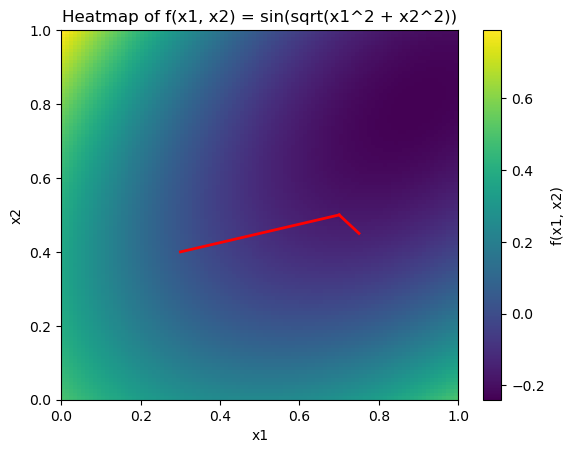

In [11]:
x1_values = np.linspace(0, 1, 100)
x2_values = np.linspace(0, 1, 100)
x1, x2 = np.meshgrid(x1_values, x2_values)
x3_fixed = 0.7


z = function([x1, x2, x3_fixed])

plt.figure()
plt.imshow(z, extent=[x1.min(), x1.max(), x2.min(), x2.max()], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='f(x1, x2)')  

line_x1 = [z0[0],(z0 + alpha * grad)[0]]
line_x2 = [z0[1],(z0 + alpha * grad)[1]]
print(line_x1, line_x2)
print(function(z0))

plt.plot(line_x1, line_x2, color='red', label='Line from z', linewidth=2)

line_x1 = [z1[0],(z1 + alpha * grad1)[0]]
line_x2 = [z1[1],(z1 + alpha * grad1)[1]]
print(line_x1, line_x2)

plt.plot(line_x1, line_x2, color='red', label='Line from z', linewidth=2)
print(function(z1))

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Heatmap of f(x1, x2) = sin(sqrt(x1^2 + x2^2))')
plt.show()

In [12]:
def adam_bfgs_update(function, grad_f, params, m, v, t, beta1=0.9, beta2=0.999, alpha=1e-3, epsilon=1e-8):

    g_t = grad_f(function, params)
    m = beta1 * m + (1 - beta1) * g_t

    v = beta2 * v + (1 - beta2) * (g_t ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    
    params = params - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
    return params, m, v

## BFGS алгоритм численный

In [13]:
def BFGS(function : Callable[[np.ndarray,], float], grad_f : Callable[[function, np.ndarray], np.ndarray], x0 : np.ndarray, max_iter=40, epsilon=1e-5):
    n = len(x0)
    x = x0
    H = np.eye(n)  
    grad_x = grad_f(function, x)
    x_new = x

    m = np.zeros_like(x0)  
    v = np.zeros_like(x0)  
    
    for i in range(max_iter):
        print(f"Итерация {i}, сходимость: {np.linalg.norm(grad_x)}, loss: {function(x)}")
        if np.linalg.norm(grad_x) < epsilon:
            print(f"Алгоритм сошелся за {i+1} итераций.")
            break
        

        p = -np.dot(H, grad_x)
        alpha = line_search(function, grad_f, x, p, c1 = 0.01, c2 = 0.9, alpha_max = 1, max_iter = int(max_iter / 1))
        
        x_new = x + alpha * p
        grad_x_new = numeric_grad_f(function, x_new)


        x_new, m, v = adam_bfgs_update(function, grad_f, x_new, m, v, i+1)
        
        s = x_new - x
        y = grad_x_new - grad_x
        
        #ro = 1.0 / (y.T @ s)
        #I = np.eye(n)
        #H = (I - ro * (s @ y.T)) @ H @ (I - ro * (y @ s.T)) + ro * (s @ s.T)
        rho = 1.0 / np.dot(y, s)
        I = np.eye(n)
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)
        
        x = x_new
        
        grad_x = grad_x_new
    
    return x

## BFGS алгоритм аналитический

In [14]:
def BFGS_anal(function, anal_grad_f, x0, max_iter=50, epsilon=1e-5):
    n = len(x0)
    x = x0
    H = np.eye(n)  # Инициализация матрицы Гессе как единичной
    grad_x = anal_grad_f(function, x)
    x_new = x

    for i in range(max_iter):
        print(np.linalg.norm(grad_x), function(x), x)
        if np.linalg.norm(grad_x) < epsilon:
            print(f"Алгоритм сошелся за {i+1} итераций.")
            break

        p = -np.dot(H, grad_x)

        alpha = line_search(function, anal_grad_f, x, p, c1 = 0.01, c2 = 0.9, alpha_max = 1, max_iter = int(max_iter / 1))

        x_new = x + alpha * p
        grad_x_new = anal_grad_f(function, x_new)

        s = x_new - x
        y = grad_x_new - grad_x

        # Шаг 5: Обновление матрицы Гессе
        #ro = 1.0 / (y.T @ s)
        #I = np.eye(n)
        #H = (I - ro * (s @ y.T)) @ H @ (I - ro * (y @ s.T)) + ro * (s @ s.T)
        rho = 1.0 / np.dot(y, s)
        I = np.eye(n)
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)

        x = x_new

        grad_x = grad_x_new

    return x

z0 = [4.3, 10.4, 4.7]

x_opt = BFGS_anal(function, anal_grad_f, z0)

print(f"Найденное оптимальное решение: {x_opt}")
print(f"Значение функции: {function(x_opt)}")

'''



'''
# Инициализация начальной точки
#z0 = [4.3, 10.4, 4.7]

# Запуск алгоритма BFGS
#x_opt = BFGS(function, numeric_grad_f, z0)

#print(f"Найденное оптимальное решение: {x_opt}")

12.168812596141006 50.84 [4.3, 10.4, 4.7]
8.557452892070163 25.030000000000005 [5.7 4.5 5.2]
4.8880173292220634 8.948419433533703 [3.93063511 3.14323725 3.1124384 ]
2.404625039526466 1.8762421292206772 [2.11181287 1.79578057 1.84764448]
1.123862433653906 0.12034649325372038 [1.53027746 1.10928067 0.84361153]
0.49705341015109566 -0.2784926986855444 [1.03406411 0.76894724 0.57931632]
0.1855029374049534 -0.36137538572644 [0.87344376 0.60199331 0.35734126]
0.02391661229440012 -0.3747902066901462 [0.76035327 0.51183005 0.26687497]
0.0018690682044932988 -0.37499906337744476 [0.7510022  0.50035624 0.2497376 ]
3.9938645356454405e-07 -0.3749999999999573 [0.74999979 0.49999992 0.25000006]
Алгоритм сошелся за 10 итераций.
Найденное оптимальное решение: [0.74999979 0.49999992 0.25000006]
Значение функции: -0.3749999999999573


'\n\n\n\n'

## L-BFGS алгоритм на основе численного задания градиента

In [15]:
def L_BFGS_numeric(function, numeric_grad_f, x0, m=5, max_iter=50, epsilon=1e-5):
    n = len(x0)
    x = x0
    grad_x = numeric_grad_f(function, x)

    s_history = []
    y_history = []
    rho_history = []

    for i in range(max_iter):
        # Отображение сходимости и значения функции на текущей итерации
        print(f"Итерация {i}, сходимость: {np.linalg.norm(grad_x)}, loss: {function(x)}")
        
        if np.linalg.norm(grad_x) < epsilon:
            print(f"Алгоритм сошелся за {i+1} итераций.")
            break

        q = grad_x
        alpha = []

        for j in range(len(s_history) - 1, -1, -1):
            s = s_history[j]
            y = y_history[j]
            rho = rho_history[j]
            a = rho * np.dot(s, q)
            alpha.append(a)
            q = q - a * y

        if len(s_history) > 0:
            gamma = np.dot(s_history[-1], y_history[-1]) / np.dot(y_history[-1], y_history[-1])
        else:
            gamma = 1.0

        r = gamma * q

        for j in range(len(s_history)):
            s = s_history[j]
            y = y_history[j]
            rho = rho_history[j]
            b = rho * np.dot(y, r)
            r = r + s * (alpha[j] - b)

        p = -r  

        alpha_step = line_search(function, numeric_grad_f, x, p, c1=0.01, c2=0.9, alpha_max=1, max_iter=int(max_iter / 1))

        x_new = x + alpha_step * p
        grad_x_new = numeric_grad_f(function, x_new)

        s = x_new - x
        y = grad_x_new - grad_x
        rho = 1.0 / np.dot(y, s)

        if np.dot(y, s) > 1e-10:
            if len(s_history) >= m:
                s_history.pop(0)
                y_history.pop(0)
                rho_history.pop(0)

            s_history.append(s)
            y_history.append(y)
            rho_history.append(rho)

        x = x_new
        grad_x = grad_x_new

    return x


## L-BFGS алгоритм на основе аналитического задания градиента

In [16]:
def L_BFGS_anal(function, anal_grad_f, x0, m=5, max_iter=50, epsilon=1e-5): # m - число сохраняемых пар
    n = len(x0)
    x = x0
    grad_x = anal_grad_f(function, x)

    # Инициализация истории для L-BFGS
    s_history = []
    y_history = []
    rho_history = []

    for i in range(max_iter):
        # print(np.linalg.norm(grad_x), function(x), x)
        if np.linalg.norm(grad_x) < epsilon:
            # print(f"Алгоритм сошелся за {i+1} итераций.")
            break

        q = grad_x
        alpha = []

        # Обратный проход для вычисления направлений (алгоритм 9.1 из источника [2])
        for j in range(len(s_history) - 1, -1, -1):
            s = s_history[j]
            y = y_history[j]
            rho = rho_history[j]
            a = rho * np.dot(s.T, q)
            alpha.append(a)
            q = q - a * y

        # Используем приближение матрицы Гессе H0
        if len(s_history) > 0:
            gamma = np.dot(s_history[-1], y_history[-1]) / np.dot(y_history[-1], y_history[-1])
        else:
            gamma = 1.0

        r = gamma * q

        for j in range(len(s_history)):
            s = s_history[j]
            y = y_history[j]
            rho = rho_history[j]
            b = rho * np.dot(y, r)
            r = r + s * (alpha[j] - b)

        p = -r 
        
        alpha_step = line_search(function, anal_grad_f, x, p, c1=0.01, c2=0.9, alpha_max=1, max_iter=int(max_iter / 1))

        x_new = x + alpha_step * p
        grad_x_new = anal_grad_f(function, x_new)

        s = x_new - x
        y = grad_x_new - grad_x
        rho = 1.0 / np.dot(y, s)

        if np.dot(y, s) > 1e-10:  # условие для обновления
            if len(s_history) >= m:
                s_history.pop(0)
                y_history.pop(0)
                rho_history.pop(0)

            s_history.append(s)
            y_history.append(y)
            rho_history.append(rho)

        x = x_new
        grad_x = grad_x_new

    return x


z0 = [4.3, 10.4, 4.7]
x_opt = L_BFGS_anal(function, anal_grad_f, z0)

print(f"Найденное оптимальное решение: {x_opt}")
print(f"Значение функции: {function(x_opt)}")

Найденное оптимальное решение: [1.33266778 0.58614102 0.36394195]
Значение функции: -0.0751018823990881


In [17]:
x_opt = [ 7.500e-01,  5.000e-01,  2.500e-01]
print(f"Значение функции: {function(x_opt)}")

Значение функции: -0.375


In [18]:
def filter_top_frequencies(df, column, freq_num):

    frequency = df[column].value_counts()
    top_values = frequency.nlargest(freq_num).index
    filtered_df = df[df[column].isin(top_values)].copy()

    replacement_dict = {value: i for i, value in enumerate(top_values)}
    filtered_df[column] = filtered_df[column].replace(replacement_dict)
    
    return filtered_df

def read_split_data(dataset = '', dataset2 = '', label = '', sep = ',', freq_num = 5):

    df = pd.read_csv(dataset, sep = sep)
    df2 = pd.read_csv(dataset2, sep = sep)


    concatenated_df = pd.concat([df, df2], axis=0, join='outer')

    df = filter_top_frequencies(concatenated_df, column = label, freq_num = freq_num)
    df = df.sample(frac=1,random_state=None).reset_index(drop=True)
    
    y = df.loc[:, label]
    df = df.drop(label, axis='columns')

    return df, y


outputs = 5
data, y = read_split_data(dataset = '/Users/user/Downloads/wine+quality/winequality-white.csv',  dataset2 = '/Users/user/Downloads/wine+quality/winequality-red.csv', label = 'quality', sep = ';', freq_num = outputs)

def custom_SVD(matrixA):
    if matrixA.shape[0] > matrixA.shape[1]:
        XTX = np.dot(matrixA.T, matrixA)  #  X^TX
        S, Vt = QR_algorithm(XTX)

        S = np.sqrt(S) 
        S_diag = np.diag(S)
        S_inv = np.linalg.inv(S_diag)

        U = np.dot(matrixA, np.dot(Vt, S_inv)) # U = X V S_inv
    else:
        XXT = np.dot(matrixA, matrixA.T)  # X^TX
        S, U = QR_algorithm(XXT)

        S = np.sqrt(S) 
        S_diag = np.diag(S)
        S_inv = np.linalg.inv(S_diag)
        #Vt = np.dot(np.dot(matrixA.T, U), S_inv)
        Vt = np.dot(S_inv, np.dot(U.T, matrixA)) # U = X V S_inv

        zero_matrix = np.zeros((matrixA.shape[1], matrixA.shape[1]))
        zero_matrix[:matrixA.shape[0], :] = Vt
        
        Vt = zero_matrix

    return U, S, Vt


def QR_decomposition(matrixA):
    matrixA_transposed = np.transpose(matrixA) # Транспонируем исходную матрицу для удобства
    n = len(np.array(matrixA)) #n - кол-во столбцов
    Q = [[0] * n for _ in range(n)] # Создаем нулевую матрицу Q
    R = [[0] * n for _ in range(n)] # Создаем нулевую матрицу R

    for i in range(n):
        v = matrixA_transposed[i].astype('float32') # Получаем вектор-столбец матрицы А, astype добавлен, т.к. возникала ошибка
        for j in range(i): # Ортоганализируем вектор v по отношению к предыдущим столбцам
            R[j][i] = np.dot(Q[j], v) # Скалярное произведение векторов
            #v -= np.multiply(R[j][i],Q[j])
            v = np.subtract(v, np.multiply(R[j][i],Q[j])) # Вычитаение проекции вектора v на вектор-столбец Q, чтобы v стал ортоганальным к Q
        # Нормализация вектора v
        R[i][i] = (sum(vi**2 for vi in v))**0.5
        Q[i] = np.divide(v, R[i][i])


    return np.transpose(Q), np.array(R)

def QR_algorithm(matrixA):
    n = matrixA.shape[0]
    eigenvalues = [[0] * n for _ in range(n)]
    eigenvectors = np.eye(n)

    for _ in range(100): #Используем 100 итераций разложения
        Q, R = QR_decomposition(matrixA)
        matrixA = np.dot(R, Q)
        eigenvectors = np.dot(eigenvectors, Q)

    # Собственные значения находятся на диагонали матрицы A
    eigenvalues = np.diag(matrixA)

    return eigenvalues, eigenvectors

def PCA_custom(df, variance_pecr = 0.9):
    data = df

    # Центрирование по медиане и маштабирование до [-1,1]
    data_centered = data - np.median(data, axis=0)
    data_centered /= np.max(np.abs(data_centered),axis=0)

    # SVD
    #U, S, Vt = svd(data_centered)
    U, S, Vt = custom_SVD(data_centered)
    n_comp = pick_components(S, variance_pecr)

    Ur = U[:,:n_comp]
    Sr = np.diag(S[:n_comp])
    data_new = np.dot(Ur, Sr)

    return data_new

def pick_components(array, variance_pecr):

    variance = array**2
    target_variance = np.sum(variance) * variance_pecr

    var_sum = 0
    num_elements = 0

    for i in variance:
        var_sum += i
        num_elements += 1
        if var_sum >= target_variance:
            break

    return num_elements

def PCA_SVD(dd,pca = 3):
    if isinstance(dd, np.ndarray):
        data_centered=dd
    else:
        dd = dd.to_numpy()
        # Центрирование по медиане и маштабирование до [-1,1]
        data_centered = dd - np.median(dd, axis=0)
        data_centered /= np.max(np.abs(data_centered),axis=0)

    dd=data_centered.T

    # SVD
    #U, S, Vt = svd(dd)
    U, S, Vt = custom_SVD(dd)

    print('VAR_2%:', (S[0]+S[1])/sum(S))
    print('VAR_3%:', (S[0]+S[1]+S[2])/sum(S))

    S=np.diag(S)

    So = S
    Sn = np.zeros((dd.shape[0], dd.shape[1]))
    Sn[:So.shape[0], :So.shape[1]] = So
    S=Sn

    S[:, pca:] = 0
    U[:, pca:] = 0
    Vt[pca:, :] = 0

    RR=U@S@Vt
    print(RR.shape)
    print(pd.DataFrame(RR).T.head())
    RR_r = []
    for i in range(RR.shape[0]):
        RR2 = RR[RR_r + [i], :]
        if np.linalg.matrix_rank(RR2) == len(RR_r) + 1:
            RR_r.append(i)

    RR_r = RR[RR_r]

    RR_itog=RR_r.T
    RR_itog

    return RR_itog

# Центрирование по медиане и маштабирование до [-1,1]
data_centered = data - np.median(data, axis=0)
data_centered /= np.max(np.abs(data_centered),axis=0)


new_data = PCA_custom(data, variance_pecr = 0.95)
new_data = pd.DataFrame(new_data)
print("---Кастомный PCA---")
print(new_data.shape)
print(new_data)
print("---------")



def split_data(data, y, train_size = 0.9):
    # Calc train size
    train_len = int(len(data) * train_size)

    # Separate test and train labels
    y_train = y[:train_len]
    y_test = y[train_len:]

    # Split test and train
    train_data = data[:train_len]
    test_data = data[train_len:]
    
    return train_data, y_train, test_data, y_test

train_data, y_train, test_data, y_test = split_data(data, y)
train_data2, y_train2, test_data2, y_test2 = split_data(new_data, y)

---Кастомный PCA---
(6462, 8)
             0         1         2         3         4         5         6  \
0    -0.346066  0.017424  0.035150  0.168104  0.002121  0.102825 -0.034449   
1     0.167566  0.343559  0.028428  0.022639  0.057509  0.014694  0.096291   
2    -0.501789 -0.131980  0.128680  0.012786 -0.020411 -0.045470 -0.034093   
3    -0.511838 -0.136547  0.210204  0.097014  0.093406  0.085171  0.009583   
4    -0.396566 -0.119222  0.503277  0.232968  0.178928 -0.082856 -0.023045   
...        ...       ...       ...       ...       ...       ...       ...   
6457  0.354478 -0.412200 -0.314639  0.097882 -0.143052  0.053351  0.050007   
6458 -0.101203 -0.065695  0.013481  0.189589 -0.025320 -0.122868  0.143225   
6459 -0.385859 -0.133633  0.304108 -0.146116 -0.172526 -0.097590 -0.008455   
6460  0.655264  0.245877 -0.151182  0.156938 -0.062735 -0.019162 -0.020856   
6461 -0.257067 -0.009103 -0.362923  0.196516  0.286511 -0.057359  0.061305   

             7  
0    -0.031073  

In [19]:
class PercNeuralNetwork(nn.Module):
    
    def __init__(self, inputs, n_inside, outputs, prob):
        super(PercNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(inputs, n_inside)
        self.fc2 = nn.Linear(n_inside, outputs)
        self.fc1_act = nn.ReLU()
        self.dropout = nn.Dropout(p=prob)
        
    def forward(self,x):
        y = self.fc1(self.dropout(x))
        y = self.fc1_act(y)
        y = self.fc2(y)
        return y

In [20]:
n_inside = 25 # Внутр размер сети
outputs = 5 # Размер выходов сети
num_epochs=125 # Количество эпох которое будет обучаться модель
batch_size=32 # Размер батча, каоторый будет одновременно подаваться в модель
learning_rate=0.0003 # Скорость обучения

In [21]:
class FullModel:
    def __init__(self, inputs_size: int, n_inside: int, outputs_size: int, prob: float, inputs_train: pd.DataFrame,
                 targets_train: pd.DataFrame, inputs_test: pd.DataFrame, targets_test: pd.DataFrame):
        super(FullModel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = PercNeuralNetwork(inputs=inputs_size, n_inside=n_inside, outputs=outputs_size, prob=prob).double()
        self.model.to(self.device)

        self.criterion = torch.nn.CrossEntropyLoss()
        self.params = self.get_params()

        inputs_train_tensor = torch.tensor(inputs_train.values, dtype=torch.float64).to(self.device)
        targets_train_tensor = torch.tensor(targets_train.values, dtype=torch.long).to(self.device)

        inputs_test_tensor = torch.tensor(inputs_test.values, dtype=torch.float64).to(self.device)
        targets_test_tensor = torch.tensor(targets_test.values, dtype=torch.long).to(self.device)

        self.inputs = inputs_train_tensor
        self.targets = targets_train_tensor

        self.inputs_test = inputs_test_tensor
        self.targets_test = targets_test_tensor

        self.cur_data = self.inputs
        self.cur_targets = self.targets

        self.train_losses = []
        self.test_losses = []
        self.test_accuracies = []
        self.f1_scores = []

    def get_params(self) -> torch.Tensor:
        return torch.cat([param.view(-1) for param in self.model.parameters()])

    def set_params(self, new_params: np.ndarray):
        new_params_tensor = torch.from_numpy(new_params)
        start = 0
        for param in self.model.parameters():
            param_length = param.numel()
            param.data = new_params_tensor[start:start + param_length].view_as(param).data
            start += param_length

    def model_loss_fn(self, params: np.ndarray) -> float:
        self.set_params(params)
        outputs = self.model(self.cur_data)
        return self.criterion(outputs, self.cur_targets).item()

    def train_with_bfgs(self, num_epochs=10, batch_num=4, log=True, use_l_bfgs=False):
        train_len = len(self.inputs)
        batch_size = np.ceil(train_len / batch_num).astype(int)
        start_time = time.time()

        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            permutation = torch.randperm(train_len).to(self.device)

            self.model.train()
            total_loss = 0

            for i in range(0, train_len, batch_size):
                indices = permutation[i:i + batch_size]
                self.cur_data = self.inputs[indices]
                self.cur_targets = self.targets[indices]

                x0 = self.get_params().detach().numpy()

                # Выбор оптимизатора в зависимости от use_l_bfgs
                if use_l_bfgs:
                    new_params = L_BFGS_numeric(self.model_loss_fn, numeric_grad_f, x0)  # Убрали 'grad_f' для `L_BFGS_numeric`
                else:
                    new_params = BFGS(self.model_loss_fn, numeric_grad_f, x0)

                self.set_params(new_params)

                outputs = self.model(self.cur_data)
                probabilities = torch.softmax(outputs, dim=1)
                predictions = torch.argmax(probabilities, dim=1)

                loss = self.criterion(outputs, self.cur_targets)
                total_loss += loss.item()

            self.model.eval()
            with torch.no_grad():
                test_output = self.model(self.inputs_test)
                probabilities = torch.softmax(test_output, dim=1)
                predictions = torch.argmax(probabilities, dim=1)

                test_loss = self.criterion(test_output, self.targets_test).item()
                test_accuracy = self.accuracy(predictions, self.targets_test)
                f1 = self.f1_score(predictions.cpu().numpy(), self.targets_test.cpu().numpy())

            self.train_losses.append(total_loss / (train_len / batch_size))
            self.test_losses.append(test_loss)
            self.test_accuracies.append(test_accuracy)
            self.f1_scores.append(f1)

            if log:
                print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {self.train_losses[-1]:.4f}, '
                      f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1 Score: {f1:.4f}')

        total_training_time = time.time() - start_time
        print(f'Training complete in {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s')
        self.visualise()

    def accuracy(self, output: torch.Tensor, labels: torch.Tensor) -> float:
        correct = (output == labels).sum().item()
        return correct / len(labels) * 100

    def f1_score(self, y_pred, y_true):
        unique_classes = np.unique(np.concatenate([y_true, y_pred]))

        f1_scores = []
        weights = []
        
        for cls in unique_classes:
            tp = np.sum((y_true == cls) & (y_pred == cls))
            fp = np.sum((y_true != cls) & (y_pred == cls))
            fn = np.sum((y_true == cls) & (y_pred != cls))
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0
            
            support = np.sum(y_true == cls)
            f1_scores.append(f1)
            weights.append(support)
        
        weighted_f1 = np.average(f1_scores, weights=weights)
        return weighted_f1

    def visualise(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(self.test_accuracies, label='Test Accuracy', color='orange')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(self.f1_scores, label='F1 Score', color='green')
        plt.title('F1 Score over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.show()


Итерация 0, сходимость: 0.5790427501057764, loss: 1.546470211718344
Итерация 1, сходимость: 0.5518226295103587, loss: 1.4985907493089758
Итерация 2, сходимость: 0.4817023084659523, loss: 1.3603234070466765
Итерация 3, сходимость: 0.47622115905097334, loss: 1.270050217291797
Итерация 4, сходимость: 0.515005630376473, loss: 1.244995910941502
Итерация 5, сходимость: 0.5833389656237751, loss: 1.2414096119354736
Итерация 6, сходимость: 0.609181498677786, loss: 1.2399269001615798
Итерация 7, сходимость: 0.5983081033884141, loss: 1.237292859404106
Итерация 8, сходимость: 0.7121579781522838, loss: 1.2336923923927074
Итерация 9, сходимость: 0.7614762038736279, loss: 1.2294400657905373
Итерация 10, сходимость: 0.838375438401367, loss: 1.2252928585226825
Итерация 11, сходимость: 0.9239622564155021, loss: 1.2243418321568438
Итерация 12, сходимость: 0.9277488159230426, loss: 1.2237503126240559
Итерация 13, сходимость: 1.0238841667046512, loss: 1.2224292638408367
Итерация 14, сходимость: 1.085855753

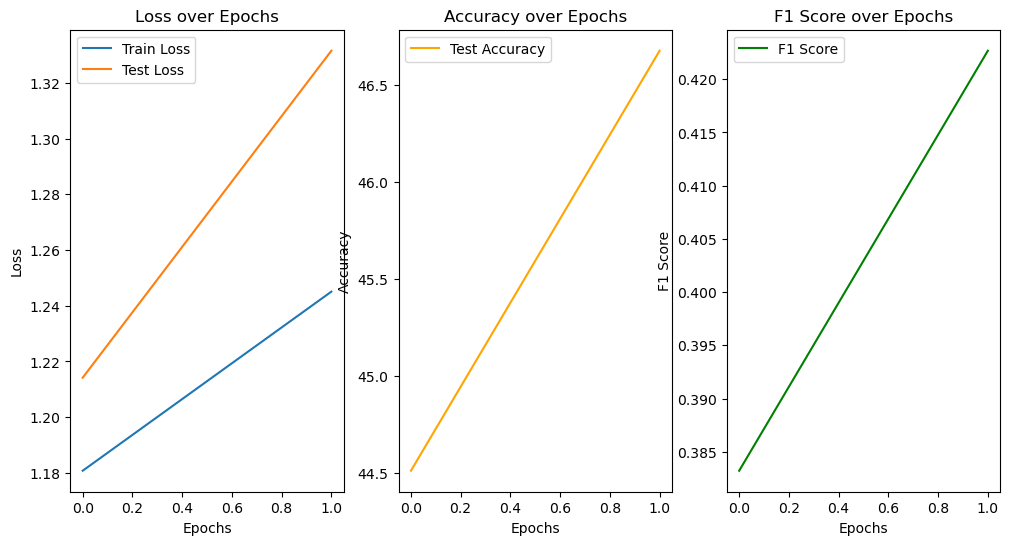

In [24]:
model2 = FullModel(inputs_size=train_data2.shape[1], n_inside=n_inside, outputs_size=outputs, prob=0.1,
                   inputs_train=train_data2, targets_train=y_train2, inputs_test=test_data2, targets_test=y_test2)


model2.train_with_bfgs(num_epochs=2, batch_num=4, log=True, use_l_bfgs=False)

Итерация 0, сходимость: 0.6892188850280782, loss: 1.5558601407296797
Итерация 1, сходимость: 0.6329120077412927, loss: 1.3777691222303732
Итерация 2, сходимость: 0.7263475063514545, loss: 1.3346506605153157
Итерация 3, сходимость: 0.8151812895202508, loss: 1.2829117088912791
Итерация 4, сходимость: 0.9837931065411616, loss: 1.2645149839785002
Итерация 5, сходимость: 1.0004912444391503, loss: 1.2623396634931336
Итерация 6, сходимость: 1.0059208303852074, loss: 1.2620556733318526
Итерация 7, сходимость: 0.916526296996832, loss: 1.2630165693567925
Итерация 8, сходимость: 0.9380465606951958, loss: 1.2619997628444681
Итерация 9, сходимость: 0.9129875461106007, loss: 1.2607595552977136
Итерация 10, сходимость: 0.9655421626528934, loss: 1.2606473355310666
Итерация 11, сходимость: 0.998043430319555, loss: 1.2622153853726588
Итерация 12, сходимость: 0.9667261723891046, loss: 1.2581194831246705
Итерация 13, сходимость: 0.9046345316784677, loss: 1.2592547668079843
Итерация 14, сходимость: 0.93507

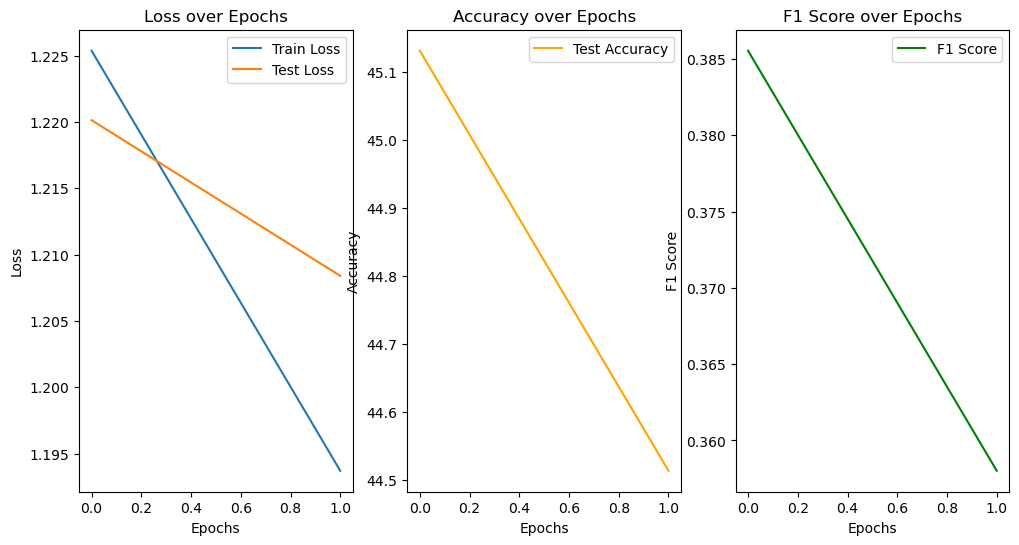

In [23]:
model2 = FullModel(inputs_size=train_data2.shape[1], n_inside=n_inside, outputs_size=outputs, prob=0.1,
                   inputs_train=train_data2, targets_train=y_train2, inputs_test=test_data2, targets_test=y_test2)


model2.train_with_bfgs(num_epochs=2, batch_num=4, log=True, use_l_bfgs=True)